<h1>Introduction</h1>

In this project I clean and transform data, analyze correlation and use linear regression to arrive at a model that predicts a house's sale price.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
%matplotlib inline

data=pd.read_csv('AmesHousing.tsv', sep='\t')
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
def transform_features(df):
    length=len(df)
    nulls=df.isnull().sum()
    cols=nulls[nulls>length*.25].index
    #Dropping columns with over 25% null values
    df=df.drop(labels=cols, axis=1)
    #Adding descriptive column
    df['years_until_remod']=df['Year Remod/Add']-df['Year Built']
    nulls=df.isnull().sum()
    cols=nulls[(nulls<length*.05) & (nulls>0)].index
    #Filling columnns with less than 5% null values with their modes
    num_df=df[cols].select_dtypes(include=['int', 'float', 'double'])
    df[num_df.columns]=num_df.fillna(num_df.mode())
    #Dropping columns that I eyeballed that were non-numeric and low variance if they were to be converted to categorical
    df=df.drop(labels=['Street', 'Utilities', 'Condition 1', 'Condition 2', 
                             'Order', 'Central Air', 'Heating', 'PID', 'Roof Matl',
                            'Sale Condition', 'Sale Type', 'Functional','Yr Sold'], axis=1)
    #Adding more descriptive columns
    df['Indoors SF']=df['Total Bsmt SF']+df['Gr Liv Area']
    df['porch_area']=df['Screen Porch']+df['3Ssn Porch']+df['Enclosed Porch']+df['Open Porch SF']
    df=df.dropna()
    return df

We dropped a lot of columns that have low variance and that are non-numeric.

<h1>Categorical conversion</h1>

Later on I use this. Some categories have high correlation with SalePrice, most don't. 

In [33]:
def convert_categorical(df):
    for column in df.columns:
        vc=df[column].value_counts()
        #This rule gets the best categories
        if len(vc)<10 and (max(vc)/len(df))<.95:
            dummies=pd.get_dummies(df[column], prefix='cat_'+column)
            df=pd.concat([df, dummies], axis=1)
            df=df.drop(labels=column, axis=1)
    return df

<h1>Train and Test</h1>

Any non-negative, whole number k value can be used here. As we will see later, this model only improves in accuracy with higher k values. 

In [5]:
def train_and_test(df,features, k):
    if k==0:
        train=df[0:1460]
        test=df[1460:]
        lr=LinearRegression()
        lr.fit(df[features], df['SalePrice'])
        predictions=lr.predict(test[features])
        mse=mean_squared_error(test['SalePrice'], predictions)
        rmse=mse**(1/2)
        return rmse
    if k==1:
        order=np.random.permutation(df.index)
        df=df.reindex(order)
        fold_one=df[0:1460]
        fold_two=df[1460:]
        l1=LinearRegression()
        l1.fit(fold_one[features], fold_one['SalePrice'])
        predict_1=l1.predict(fold_two[features])
        l2=LinearRegression()
        l2.fit(fold_two[features], fold_two['SalePrice'])
        predict_2=l2.predict(fold_one[features])
        mse_1=mean_squared_error(fold_two['SalePrice'], predict_1)
        rmse_1=mse_1**(1/2)
        mse_2=mean_squared_error(fold_one['SalePrice'], predict_2)
        rmse_2=mse_2**(1/2)
        avg_rmse=np.mean(rmse_1+rmse_2)
        return avg_rmse
    if k>1:
        kf=KFold(k, shuffle=True, random_state=1)
        lr=LinearRegression()
        mses=cross_val_score(lr, df[features], df['SalePrice'], scoring='neg_mean_squared_error',
        cv=kf)
        rmses=np.sqrt(np.absolute(mses))
        avg_rmse=np.mean(rmses)
        return avg_rmse
        

In [6]:
pd.set_option('display.max_columns',500)
transform_data=transform_features(data)

<h1>Correlation</h1>

Mostly square footage seems to correlate with SalePrice. The heatmap doesn't take into account the categorical columns, which are too numerous to be visually displayed. The text just overruns itself and there's too much data at once to analyze. That being said, we can see relationships like Garage Area and Garage Cars being highly correlated to each other. Also the columns I created earlier have high correlation to their source columns. 

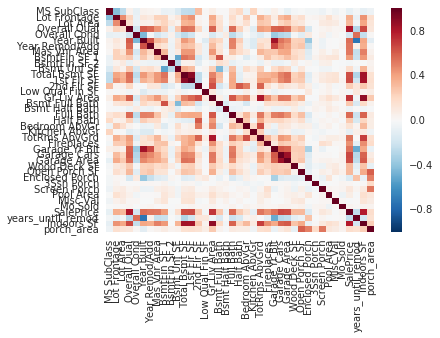

In [27]:
import seaborn as sns

num_train=transform_data.select_dtypes(include=['int', 'float', 'double'])
corrs=num_train.corr()
saleprice_corrs=corrs['SalePrice']
sns.heatmap(corrs)

In [28]:
saleprice_corrs.sort_values(ascending=False)

SalePrice            1.000000
Overall Qual         0.803153
Indoors SF           0.792386
Gr Liv Area          0.717469
Garage Cars          0.666589
Garage Area          0.651103
1st Flr SF           0.649510
Total Bsmt SF        0.648084
Full Bath            0.567360
Year Built           0.557264
Garage Yr Blt        0.539305
Year Remod/Add       0.535272
TotRms AbvGrd        0.533801
Mas Vnr Area         0.525153
Fireplaces           0.458617
BsmtFin SF 1         0.425338
Lot Frontage         0.362810
Open Porch SF        0.327231
Wood Deck SF         0.325869
Lot Area             0.321952
Bsmt Full Bath       0.270874
Half Bath            0.265087
2nd Flr SF           0.246508
Bsmt Unf SF          0.176815
porch_area           0.176756
Bedroom AbvGr        0.144602
Screen Porch         0.110068
Pool Area            0.075494
Mo Sold              0.031348
3Ssn Porch           0.016291
Misc Val            -0.014373
BsmtFin SF 2        -0.024354
Low Qual Fin SF     -0.024987
Bsmt Half 

<h1>Picking Features</h1>

I picked the top three from the above list. Later on I use KBest Features with chi2 to get a different set.

In [76]:
def select_features(df):
    features=['Gr Liv Area', 'Overall Qual', 'Indoors SF']
    selection=features[:]
    selection.append('SalePrice')
    return df[selection], features

In [78]:
prepared_data, features=select_features(transform_data)

In [79]:
train_and_test(prepared_data, features, 101)

37386.637003615571

<h1>Seeing where the K values plateau</h1>

They don't. Not at k=500, anyway. 

In [80]:
avg_rmses=dict()
for k in range(0,500,10):
    avg_rmse=train_and_test(prepared_data, features, k)
    avg_rmses[k]=avg_rmse
avg_rmses

{0: 41430.067956909115,
 10: 40497.856670310284,
 20: 39863.332207677791,
 30: 39275.165046658709,
 40: 39121.78735073896,
 50: 38572.512924196992,
 60: 38367.827510331685,
 70: 38158.861064972611,
 80: 37800.199946040775,
 90: 37403.917262662304,
 100: 37183.082508718966,
 110: 37109.565431626281,
 120: 37060.956607617554,
 130: 36832.641993600475,
 140: 36501.109199247483,
 150: 36524.501730468139,
 160: 36288.96493354399,
 170: 36209.611991883947,
 180: 36001.07223991819,
 190: 35738.443875987556,
 200: 35718.059249633872,
 210: 35593.984077235516,
 220: 35577.498513873114,
 230: 35471.797274891767,
 240: 35500.314951464876,
 250: 35165.950399242975,
 260: 35014.943914215364,
 270: 34987.053945903674,
 280: 34991.212014188095,
 290: 34771.232866606333,
 300: 34726.298917599124,
 310: 34694.519244802505,
 320: 34598.349720139915,
 330: 34400.661669130524,
 340: 34403.039734681784,
 350: 34263.662096047228,
 360: 34302.015744062264,
 370: 34210.173049972553,
 380: 34021.923362846741,


490

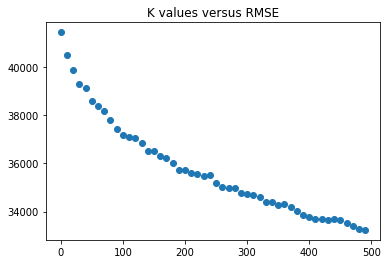

In [81]:
x=np.arange(100)
plt.scatter(list(avg_rmses.keys()), list(avg_rmses.values()))
plt.title('K values versus RMSE')
min(avg_rmses, key=avg_rmses.get)

<h1>Alternate Feature Selection with SelectKBest</h1>

First I get category columns with pandas dummies in the function convert_categorical from earlier. Then I get the 10 best features according to chi2. The accuracy ends up being lower than with the other three best features selected earlier.

The avg rmse keeps getting lower with higher K values.

In [34]:
cat_data=convert_categorical(transform_data)

In [68]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#Some data manipulation to prepare for SelectKBest
remove=list(cat_data.select_dtypes(include=['object']).columns)
cat_data=cat_data.drop(labels=remove, axis=1)
cols=list(cat_data.columns)
cols.remove('SalePrice')
X=np.absolute(cat_data[cols])
y=cat_data['SalePrice']

#Use chi2 with SelectKBest
test = SelectKBest(score_func=chi2, k=10)
fit = test.fit(X, y)

mask = test.get_support()
new_features = X.columns[mask]
new_features

Index(['Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
       'Bsmt Unf SF', '2nd Flr SF', 'Low Qual Fin SF', 'Pool Area', 'Misc Val',
       'Indoors SF'],
      dtype='object')

In [71]:
train_and_test(cat_data, new_features, 101)

45145.201768645202

<h1>Conclusion</h1>

The best model seems to have a very large K and use the top three features that correlate with SalePrice.